## Load data

In [1]:
#load data
import pandas as pd

In [2]:
dtypesBvot = {
    'NUMTOUR' :    'int64',
    'CODDPT' :    'object',
    'CODSUBCOM' :  'int64',
    'LIBSUBCOM' : 'object',
    'CODBURVOT' : 'object',
    'CODCAN' :     'int64',
    'LIBCAN' :    'object',
    'NBRINS' :     'int64',
    'NBRVOT' :     'int64',
    'NBREXP' :     'int64',
    'NUMDEPCAND' : 'int64',
    'LIBLISEXT' : 'object',
    'CODNUA' :    'object',
    'NBRVOIX' :    'int64',
}

dtypesCantons = {
    'Code du département' :    'object',
}

departements = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95']

#load data
data_canton_FR = pd.read_excel(r'../dataset/raw/Dep_15_Resultats_T1_complet.xlsx', sheet_name='Cantons', header=2, dtype=dtypesCantons)
dataBvot = pd.read_csv('../dataset/raw/DP15_Bvot_T1T2.csv', delimiter=';', dtype=dtypesBvot)

dataBvot = dataBvot[dataBvot['CODDPT'].isin(departements)]
data_canton_FR = data_canton_FR[data_canton_FR['Code du département'].isin(map(int, departements))]

dataT1Bvot = dataBvot[dataBvot.NUMTOUR==1]
dataT2Bvot = dataBvot[dataBvot.NUMTOUR==2]

data_canton_FR.shape

(1969, 103)

In [3]:
################################# fonction utile #############################
def saveData(data, loc):
    # save cher_data as excel
    writer = pd.ExcelWriter(loc)
    
    # write dataframe to excel
    data.to_excel(writer)

    # save the excel
    writer.save()

############################# Format des donnees brute ##############################

def getNbBinomes(data):
    return len([header for header in data.columns if "Binôme" in header])

def explodeLines(data):
    initdf = data[['Code du département', 'Libellé du département', 'Code du canton', 
            'Libellé du canton', 'Inscrits', 'Abstentions', '% Abs/Ins', 'Votants',
            '% Vot/Ins', 'Blancs', '% Blancs/Ins', '% Blancs/Vot', 'Nuls', '% Nuls/Ins',
            '% Nuls/Vot', 'Exprimés', '% Exp/Ins', '% Exp/Vot']]

    headers = ['N°Panneau', 'Nuance', 'Binôme', 'Sièges', 'Voix', '% Voix/Ins', '% Voix/Exp']
    
    df = pd.DataFrame()
    for i in range(getNbBinomes(data)):
        partidf = data[[h+'.'+str(i) if i!=0 else h for h in headers]]
        partidf = pd.concat([initdf, partidf], axis=1)
        partidf.columns = pd.Index(initdf.columns.values.tolist() + headers)
        df = pd.concat([df, partidf])
    
    # Remove useless rows   
    df = df.dropna(how='all', subset=headers)
    
    return df

In [4]:
#explode line 
data_canton_FR = explodeLines(data_canton_FR)

## Dictionnaire des duels

In [5]:
#################################### Dictionnaire des duels #####################################

def getNuanceOfElected(data, col_siege='Sièges', col_nuance='Nuance'):
    elected = data[data[col_siege]=='Elus']
    return list(elected[col_nuance]) if len(elected)!=0 else None

def filterBestNuances(data, col_nuance='Nuance', criteria=12.50):
    bestCandidat = data[data['% Voix/Ins']>= criteria]
    
    if bestCandidat.empty or len(bestCandidat)==1:
        bestCandidat = data.sort_values(by='Voix', ascending=False).iloc[0:2,:]

    return list(bestCandidat[col_nuance])

def getDuels(data, dep, col_dep='Code du département', col_canton='Code du canton', col_siege='Sièges', col_nuance='Nuance',count=None):
    '''
        ATTENTION : data doit etre EXPLODE !
    '''
    data = data[data[col_dep]==dep]
    duels = dict()
    for canton in data[col_canton].unique():
        data_canton = data[data[col_canton]==canton]
        # allow to know if there is a majority in the canton
        elected = getNuanceOfElected(data_canton, col_siege=col_siege, col_nuance=col_nuance) 
        
        if elected is not None:
            count+=1
            duels[str(canton)]= elected
        else:
            duels[str(canton)] = filterBestNuances(data_canton)
    return (duels, count) if count is not None else duels

def optimizeDuelDict(duels):
    optdict = dict()
    for dep, duelDepDict in duels.items():
        for canton, duelList in duelDepDict.items():
            key = ':'.join(duelList)
            if key in optdict.keys():
                if dep in optdict[key].keys():
                    optdict[key][dep].append(int(canton))
                else:
                    optdict[key][dep]=[int(canton)]
            else:
                optdict[key]= dict([(dep, [int(canton)])])
    return optdict

In [6]:
#dictionnaire des duels
duels = dict()
count=0
for dep in data_canton_FR['Code du département'].unique():
    duels[str(dep)], count= getDuels(data_canton_FR, dep, count=count)
    if duels[str(dep)]==[]:
        print('empty list for dep : ', dep)

#dictionnaire ooptimize
optDuels = optimizeDuelDict(duels)
win = [duel.split(':') for duel in list(optDuels.keys()) if len(duel.split(':'))<2]


In [7]:
duels['14']
count=0
for winner in win:
    count += len(optDuels[winner[0]])
count

82

## Preparation des donnees pour le reseau de neuronne

In [8]:
#################################### Data Processing ####################################

def prepareInputDataExploded(data):
    tmp = data[['NUMTOUR', 'CODDPT', 'CODSUBCOM', 'LIBSUBCOM', 'CODBURVOT', 'CODCAN',
            'LIBCAN', 'NBRINS', 'NBRVOT', 'NBREXP', 'CODNUA', 'NBRVOIX']].copy()

    # correction = [str(i) for i in range(1,10)]

    # #remove canton where there is a winner in the 1st turn
    # for winner in win:
    #      for dep, can in optDuels[winner[0]]:
    #         if dep in correction:
    #             tmp = tmp.loc[~((tmp['CODDPT']=='0'+dep) & (tmp['CODCAN']==int(can)))]
    #         else:
    #             tmp = tmp.loc[~((tmp['CODDPT']==dep) & (tmp['CODCAN']==int(can)))]
    


    # Compute missing data
    tmp['NBRABS'] = tmp['NBRINS'] - tmp['NBRVOT']
    tmp['NBRBLCNUL'] = tmp['NBRVOT'] - tmp['NBREXP']
    tmp['%ABS/INS'] = tmp['NBRABS'] / tmp['NBRINS']
    tmp['%BLCNUL/VOT'] = tmp['NBRBLCNUL'] / tmp['NBRVOT']
    tmp['%EXP/VOT'] = tmp['NBREXP'] / tmp['NBRVOT']
    tmp['%VOIX/EXP'] = tmp['NBRVOIX'] / tmp['NBREXP']

    nuances = getAllNuances(data)
    statsFeatures = ['NBRINS', 'NBREXP', '%ABS/INS', '%BLCNUL/VOT', '%EXP/VOT']
    idFeatures = ['CODDPT', 'CODCAN', 'CODSUBCOM', 'CODBURVOT']

    exprimes = tmp[idFeatures + ['NBREXP']].drop_duplicates().sort_values(idFeatures)['NBREXP']
    stats = tmp[idFeatures + statsFeatures].drop_duplicates()[statsFeatures]
    ids = tmp[idFeatures].drop_duplicates()

    # Create [%Voix] and fill it
    voix = pd.DataFrame(0, index=data.index, columns=nuances)
    for parti in nuances:
        voix[parti][data['CODNUA']==parti] = tmp[tmp['CODNUA']==parti]['NBRVOIX']
    voix = pd.concat([tmp[idFeatures], voix], axis=1).groupby(idFeatures).sum()[nuances]
    voix.index = exprimes.index

    # Concat with computed stats and divide almost everything by Exprimés
    voix = voix.divide(exprimes, axis=0)
    X = pd.concat([stats, voix], axis=1)
    X.index = pd.MultiIndex.from_frame(ids)
    return X.sort_values(['CODDPT', 'CODCAN', 'CODSUBCOM', 'CODBURVOT']).fillna(0)

def getAllNuances(data, colNuance='CODNUA', fmt='exploded'):
    if fmt not in ['exploded', 'line']:
        raise ValueError("format parameter must be 'exploded' or 'line'")
    
    if fmt == 'exploded':
        nuances = data[colNuance].unique()
    
    if fmt == 'line':
        nuances = np.array([])
        nuances_tmp = data[colNuance].fillna(0)
        for c in nuances_tmp:
            nuances = np.append(nuances, nuances_tmp[c])
        nuances = np.unique(nuances[nuances!=0])
    
    return sorted(nuances)

# retourne un dataset associe a un duel
def extractDuelRaw(X, y, duel, col_canton='CODCAN', col_dep='CODDPT'):
    correction = [str(i) for i in range(1,10)]
    X_duel = pd.DataFrame()
    y_duel = pd.DataFrame()

    #remove canton where there is a winner in the 1st turn
    for dep, cantonList in optDuels[':'.join(duel)].items():
        X_duel = pd.concat([X_duel, X.loc[( X[col_dep] == (dep if dep not in correction else '0'+dep) ) & ( X[col_canton].isin(cantonList) )]])
        y_duel = pd.concat([y_duel, y.loc[( y[col_dep] == (dep if dep not in correction else '0'+dep) ) & ( y[col_canton].isin(cantonList) )]])
    
    return (X_duel, y_duel)

def prepareLabelsExploded(data, oneHotEncode=False):
    nuances = getAllNuances(data)
    idFeatures = ['CODDPT', 'CODCAN', 'CODSUBCOM', 'CODBURVOT']

    exprimes = data[idFeatures+['NBREXP']].groupby(idFeatures).first()

    # Create [%Voix] and fill it
    voix = pd.DataFrame(0, index=data.index, columns=nuances)
    for parti in nuances:
        voix[parti][data['CODNUA']==parti] = data[data['CODNUA']==parti]['NBRVOIX']
    voix = pd.concat([data[idFeatures], voix], axis=1).groupby(idFeatures).sum().sort_values(idFeatures)[nuances]

    # Concat with computed stats and divide voix by exprimes
    y = voix.divide(exprimes['NBREXP'], axis=0)
    return y.fillna(0)

In [9]:
def testna(data):
    return len(data[data.isna().any(axis=1)])

In [54]:
#prepare les donnees
from sklearn.model_selection import train_test_split


datasetDuels = dict()
for duel in optDuels:
    duel = duel.split(':')
    if len(duel)>=2:

        #Selecting data
        X_duel, y_duel  = extractDuelRaw(dataT1Bvot, dataT2Bvot , duel)

        print('\n---------- Duel : ', duel, '-----------')
        print('Preparing input data... ', end='')
        X = prepareInputDataExploded(X_duel)
        print('OK')
        print('Preparing labels... ', end='')
        y = prepareLabelsExploded(y_duel)
        print('OK')
        assert X.shape[0]==y.shape[0]
        if len(y.columns)<2:
            print("Skipped")
            continue

        print('X_duel', testna(X_duel))
        print('y_duel', testna(y_duel))
        print('X', testna(X))
        print('y', testna(y))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,train_size=0.8, random_state=42)

        if len(duel)!=len(y.columns):
            print('New duel : ', duel)

        duel = [d for d in duel if d in y.columns]
        if ':'.join(duel) in datasetDuels:
            oldX_train, oldX_test, oldy_train, oldy_test = datasetDuels[':'.join(duel)]
            X_train = pd.concat([X_train, oldX_train])
            X_test = pd.concat([X_test, oldX_test])
            y_train = pd.concat([y_train, oldy_train])
            y_test = pd.concat([y_test, oldy_test])
        datasetDuels[':'.join(duel)] = (X_train, X_test, y_train, y_test)

        print(f'shape xtrain {X_train.shape} shape ytrain {y_train.shape} || shape xtest {X_test.shape} shape ytest {y_test.shape}')


---------- Duel :  ['BC-UD', 'BC-FN'] -----------
Preparing input data... OK
Preparing labels... OK
X_duel 0
y_duel 0
X 0
y 0
shape xtrain (8616, 23) shape ytrain (8616, 2) || shape xtest (2155, 23) shape ytest (2155, 2)

---------- Duel :  ['BC-UG', 'BC-UD', 'BC-FN'] -----------
Preparing input data... OK
Preparing labels... OK
X_duel 0
y_duel 0
X 0
y 0
shape xtrain (2345, 16) shape ytrain (2345, 3) || shape xtest (587, 16) shape ytest (587, 3)

---------- Duel :  ['BC-UG', 'BC-FN'] -----------
Preparing input data... OK
Preparing labels... OK
X_duel 0
y_duel 0
X 0
y 0
shape xtrain (1573, 23) shape ytrain (1573, 2) || shape xtest (394, 23) shape ytest (394, 2)

---------- Duel :  ['BC-UG', 'BC-UD'] -----------
Preparing input data... OK
Preparing labels... OK
X_duel 0
y_duel 0
X 0
y 0
shape xtrain (2449, 19) shape ytrain (2449, 2) || shape xtest (613, 19) shape ytest (613, 2)

---------- Duel :  ['BC-FN', 'BC-UMP'] -----------
Preparing input data... OK
Preparing labels... OK
X_duel 

KeyboardInterrupt: 

## build models

In [11]:
import tensorflow as tf
from matplotlib import pyplot

In [44]:
tf.keras.backend.clear_session()

models = dict()
for duel, dataset in datasetDuels.items():
    X_train, X_test, y_train, y_test = dataset

    model = tf.keras.Sequential()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(11,)))
    model.add(tf.keras.layers.Dense(32, activation='elu'))
    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='softmax'))

    opt = tf.keras.optimizers.Adagrad(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    models[duel] = model
    

In [53]:
# i = 0
# for duel, model in models.items():
    # i+=1
    # if i>10:
    #     break
# X_train, X_test, y_train, y_test = datasetDuels[':'.join(['BC-UD', 'BC-SOC'])]
# model = models[':'.join(['BC-UD', 'BC-SOC'])]


dict_keys(['BC-UD:BC-FN', 'BC-UG:BC-UD:BC-FN', 'BC-UG:BC-FN', 'BC-UG:BC-UD', 'BC-FN:BC-UMP', 'BC-UD:BC-UG', 'BC-UMP:BC-FN', 'BC-SOC:BC-UD:BC-FN', 'BC-UDI:BC-UMP:BC-FN', 'BC-FN', 'BC-COM:BC-UD', 'BC-DVD:BC-FG', 'BC-UG:BC-DVD', 'BC-COM:BC-DVD:BC-FN', 'BC-RDG:BC-DVD:BC-FN', 'BC-SOC:BC-DVD', 'BC-SOC:BC-UMP', 'BC-COM', 'BC-DVD:BC-FN', 'BC-SOC:BC-UMP:BC-FN', 'BC-DVG:BC-FN', 'BC-SOC:BC-UD', 'BC-SOC:BC-FN', 'BC-UD:BC-FG', 'BC-FG:BC-SOC:BC-UD', 'BC-UMP:BC-EXD', 'BC-DVG:BC-DVD', 'BC-DVG:BC-UMP', 'BC-DVD:BC-UG', 'BC-DVD', 'BC-DVG:BC-UD:BC-DVD', 'BC-DIV:BC-UD:BC-DVD', 'BC-UD', 'BC-UMP', 'BC-COM:BC-UD:BC-FN', 'BC-UG:BC-UMP', 'BC-UDI', 'BC-UG:BC-DVD:BC-FN', 'BC-UG:BC-UMP:BC-FN', 'BC-SOC:BC-UDI:BC-FN', 'BC-DVD:BC-DVD:BC-FN', 'BC-FN:BC-UDI', 'BC-DVG:BC-UD:BC-FN', 'BC-UD:BC-DVD', 'BC-DVG:BC-DVD:BC-FN', 'BC-SOC:BC-DVG', 'BC-SOC', 'BC-SOC:BC-DVG:BC-FN', 'BC-SOC:BC-DVD:BC-FN', 'BC-RDG:BC-UDI', 'BC-SOC:BC-UDI', 'BC-UG:BC-UDI:BC-DVD', 'BC-RDG:BC-DVD', 'BC-FN:BC-UD', 'BC-COM:BC-FN', 'BC-FN:BC-DVG', 'BC-FN:BC


------------------- Duel : BC-FG:BC-UMP -----------------
Train: 0.737, Test: 0.600


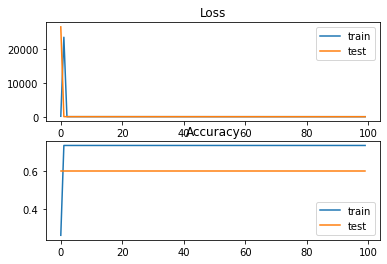

In [37]:
history = model.fit(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), epochs=100, verbose=0)
print('\n------------------- Duel :', duel, '-----------------')

# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [23]:
history.history['loss']

[0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584624469280243,
 0.19584622979164124,
 0.19584622979164124,
 0.19584624469280243,
 0.19584622979164124,
 0.19584624469280243,
 0.19584624469280243,
 0.19584622979164124,
 0.19584621489048004,
 0.19584622979164124,
 0.19584621489048004,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584624469280243,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584624469280243,
 0.19584622979164124,
 0.19584621489048004,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584624469280243,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584622979164124,
 0.19584624469280243,
 0.19584622979164124,
 0.1958462